In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Set plot style
sns.set_style('whitegrid')

In [20]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [21]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [22]:
df.isna().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


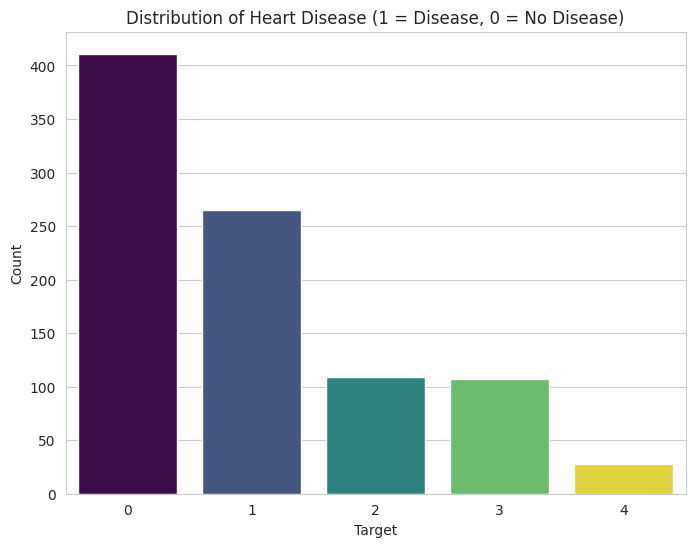

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

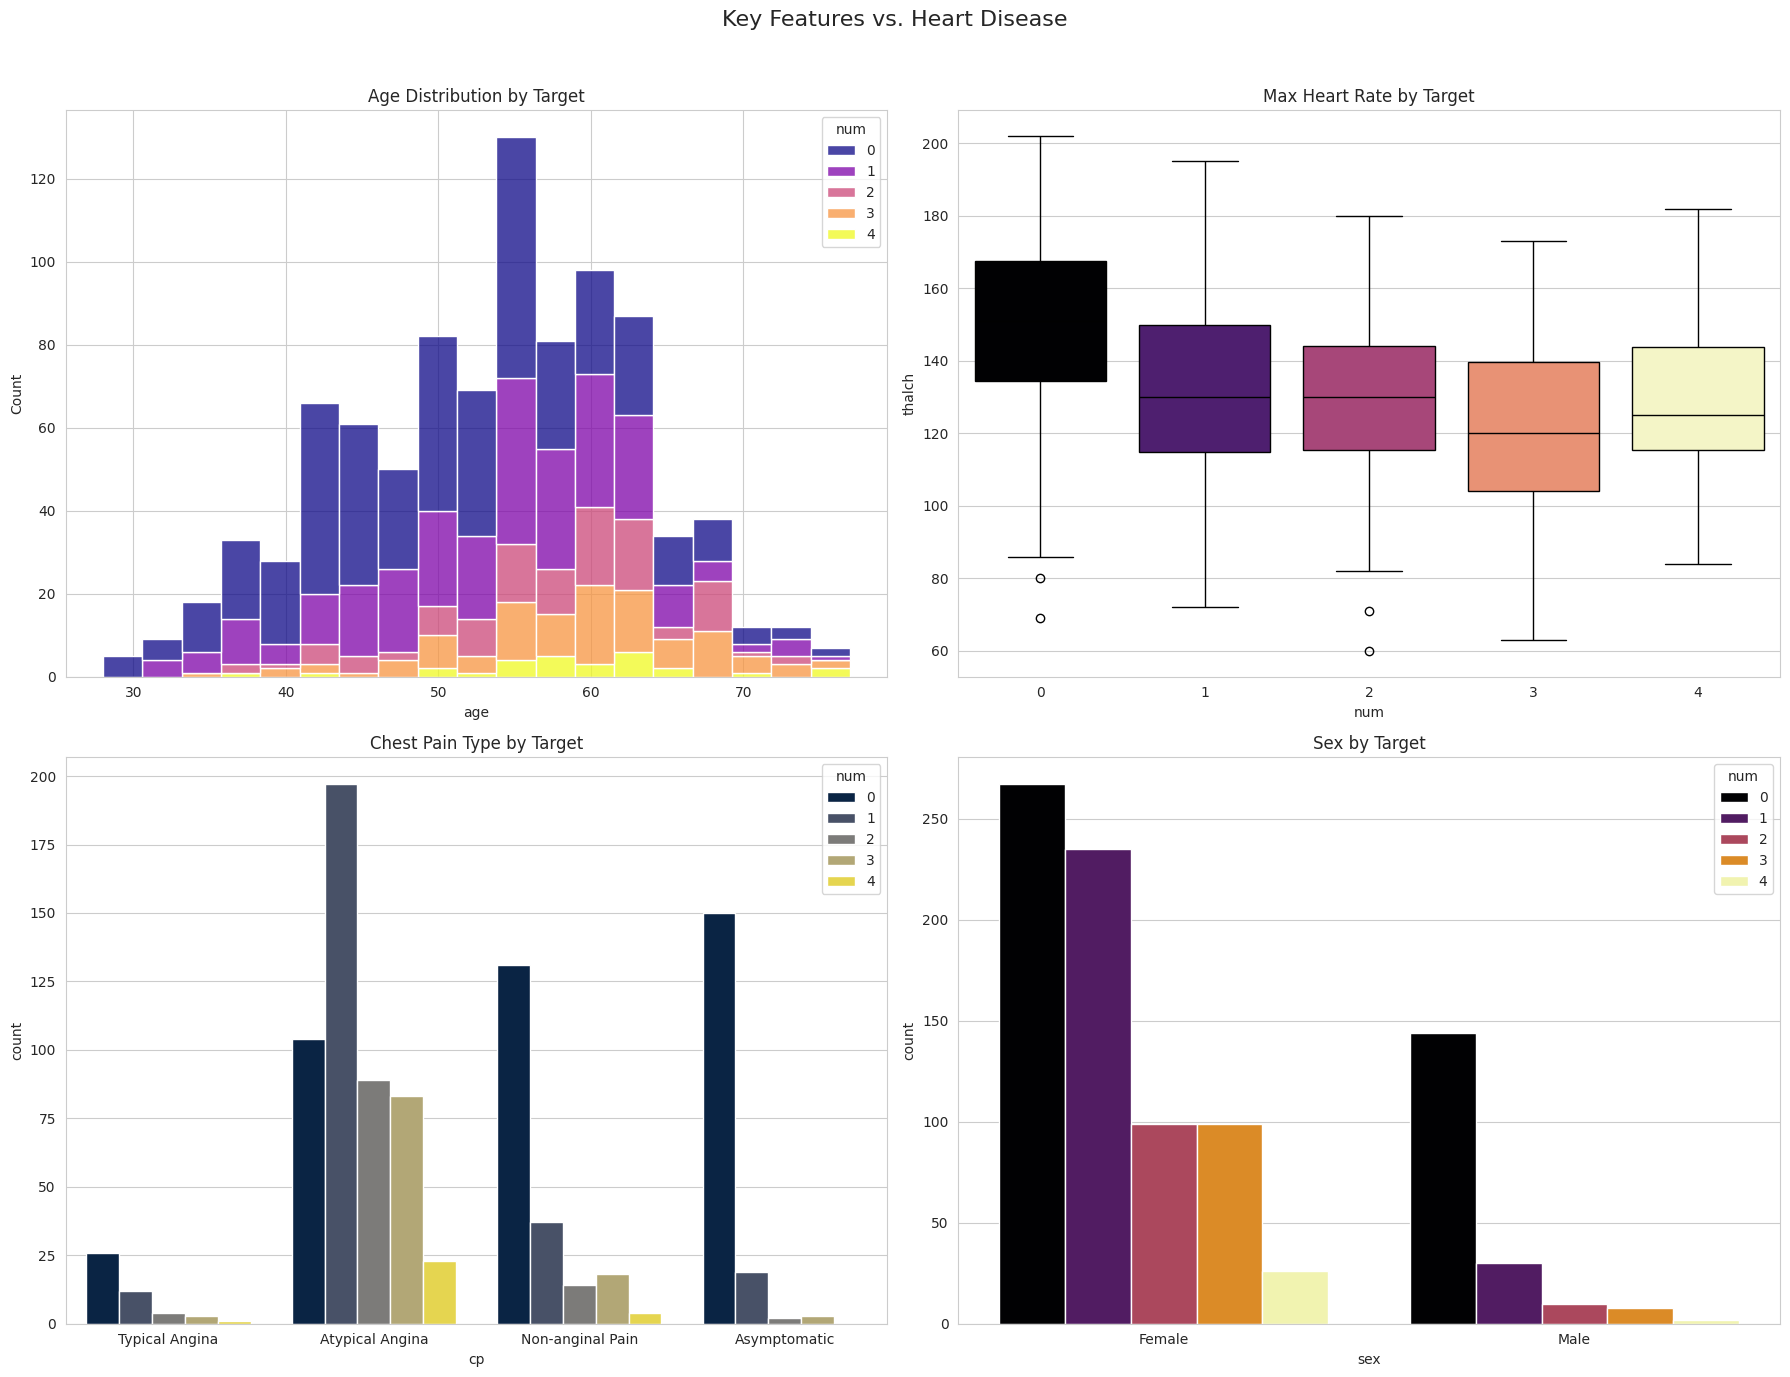

In [24]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

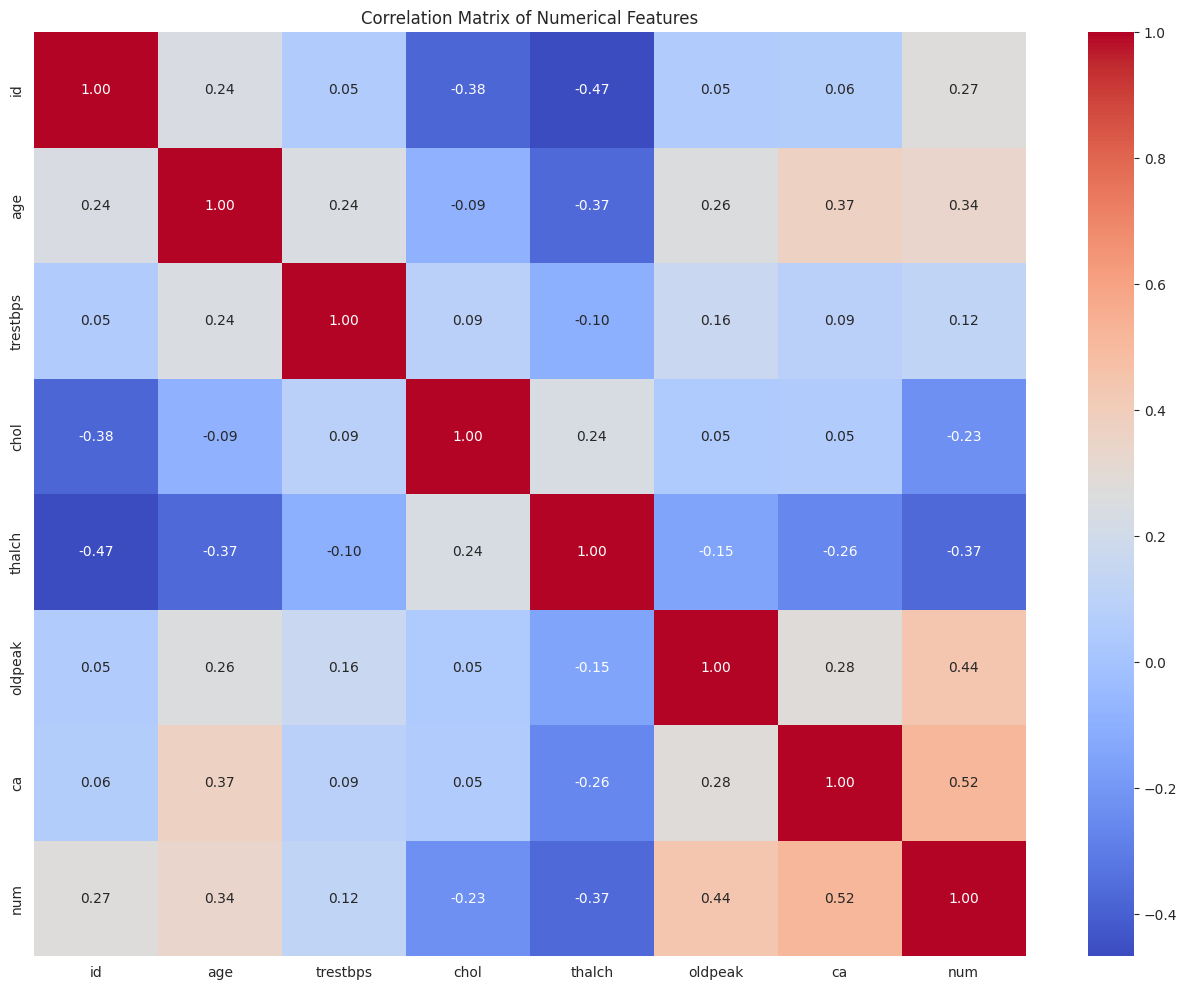

In [25]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [26]:
from sklearn.impute import SimpleImputer

# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)


# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Added imputation for categorical features
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Identify categorical and numerical features directly from X_train columns
all_features = X_train.columns.tolist()
categorical_features = [col for col in all_features if X_train[col].dtype == 'object']
numerical_features = [col for col in all_features if X_train[col].dtype != 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

Numerical features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [28]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [29]:
from sklearn.svm import SVC

# Create the SVM pipeline
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', SVC(random_state=42))])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNN pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier())])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

In [31]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred_knn, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.49      0.57      0.53        53
           2       0.30      0.14      0.19        22
           3       0.16      0.19      0.17        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.35      0.35      0.34       184
weighted avg       0.55      0.58      0.56       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        82
           1       0.50      0.53      0.51        53
           2       0.23      0.14      0.17        22
           3       0.14      0.14      0.14        21
           4       0.00      0.00      0.00         6

    accuracy                           0.56       184
   macro avg       0.32      0.33      0.32       184
we

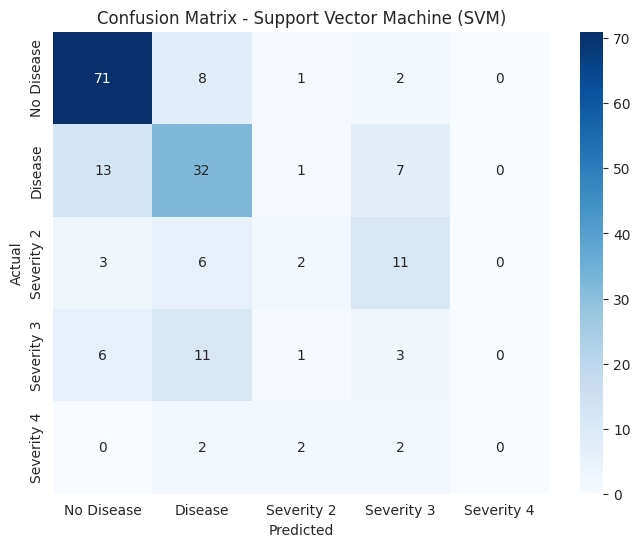

In [32]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'], yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()

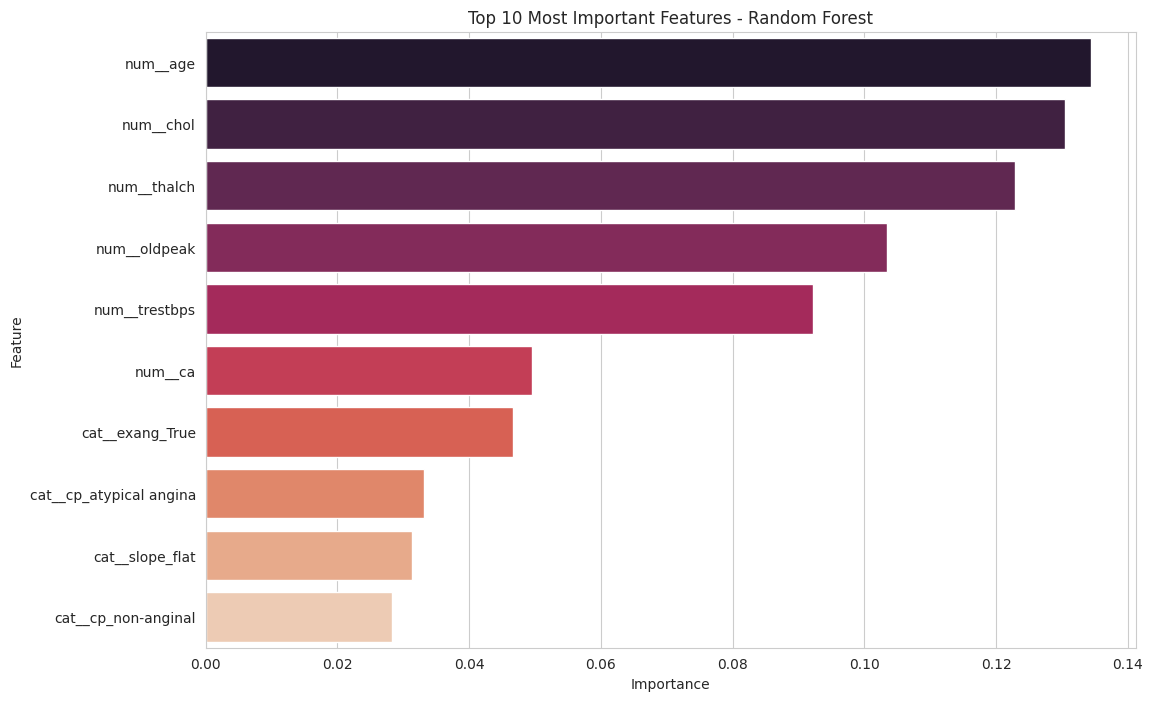

In [33]:
# Extract feature names after one-hot encoding
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the trained model
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 10 Most Important Features - Random Forest')
plt.show()

### Submission



1.  **Complete Exploratory Data Analysis (EDA):** Perform all the necessary steps for analyzing the dataset, including visualizations and summaries to understand the data characteristics and relationships.
2.  **Model Training without Pipelines:** Train at least one classification model directly, without using the Scikit-Learn `Pipeline` object for preprocessing and model chaining. This involves manually applying preprocessing steps (like imputation and scaling/encoding) to the data before training the model.
3.  **Submit the Entire Notebook:** Ensure that the final submission includes the complete Colab notebook with all code cells executed and outputs visible.



Shape: (920, 16)

Columns:
 ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

Dtypes:
 id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

Sample:
    id  age   sex    dataset              cp  trestbps   chol    fbs  \
0   1   63  Male  Cleveland  typical angina     145.0  233.0   True   
1   2   67  Male  Cleveland    asymptomatic     160.0  286.0  False   
2   3   67  Male  Cleveland    asymptomatic     120.0  229.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hy

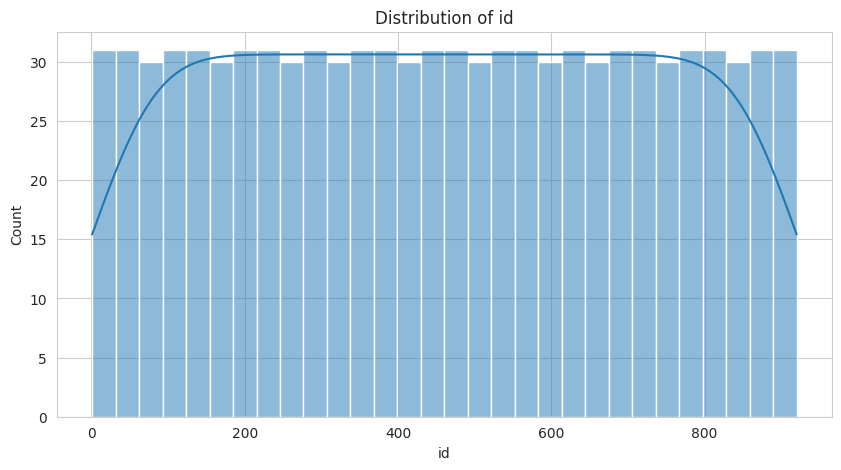

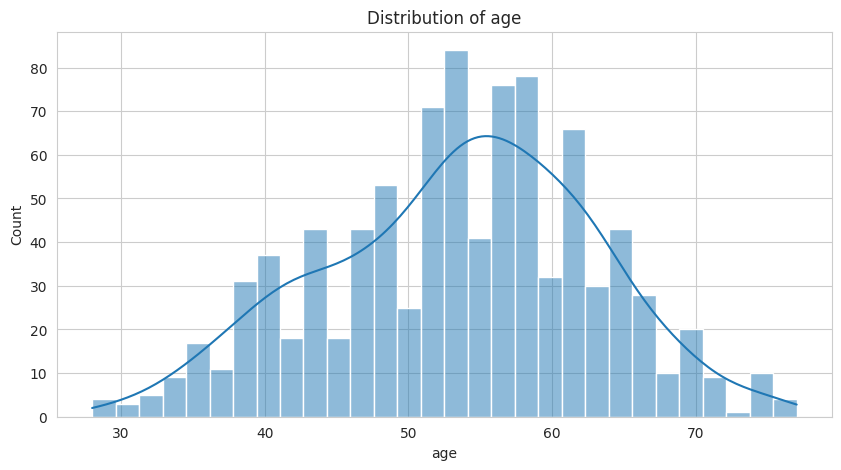

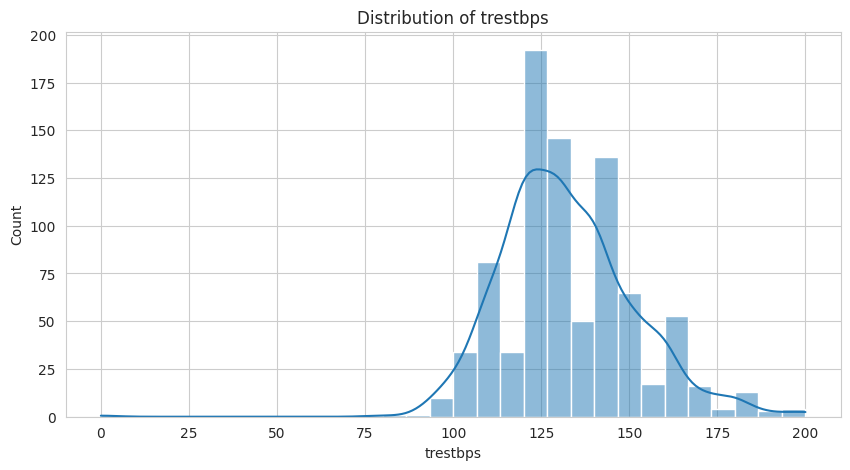

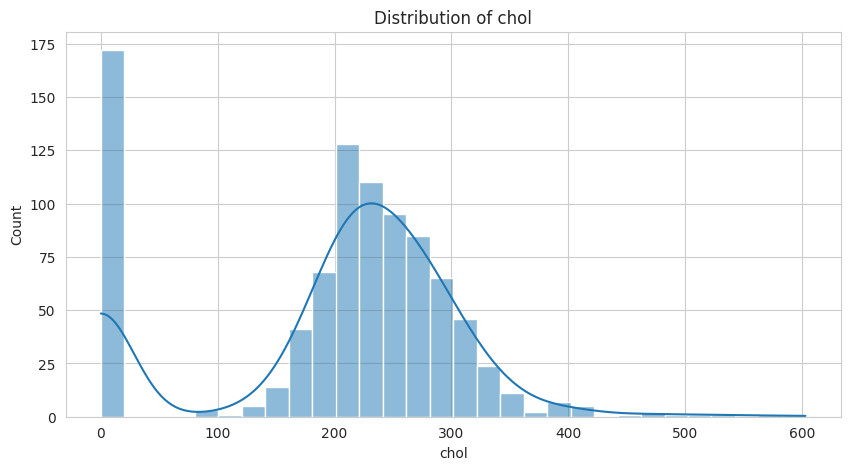

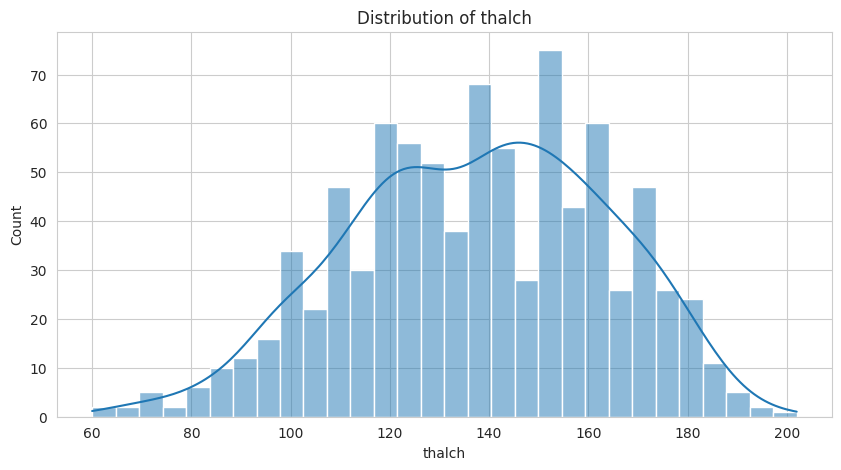

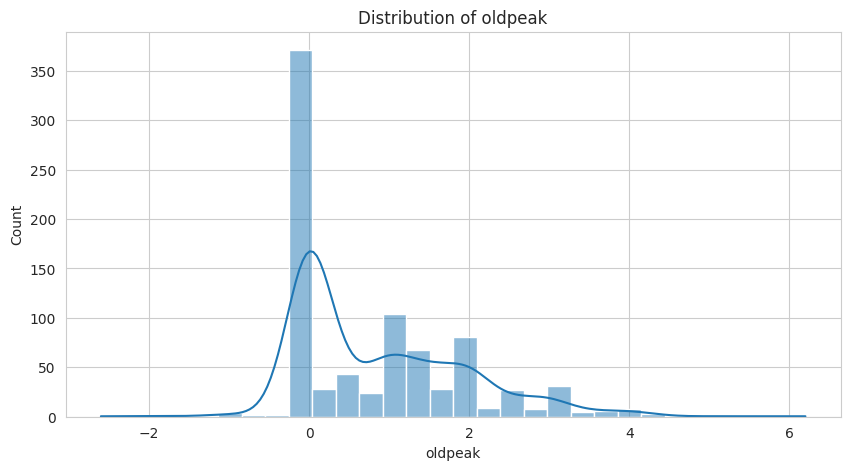

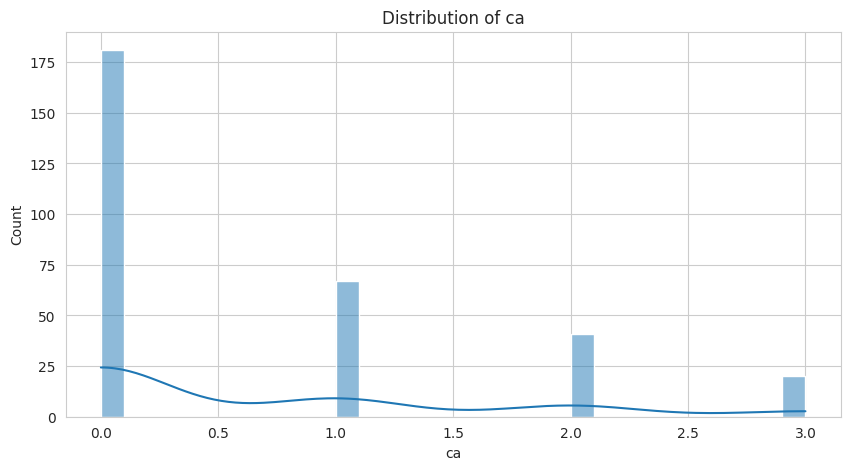

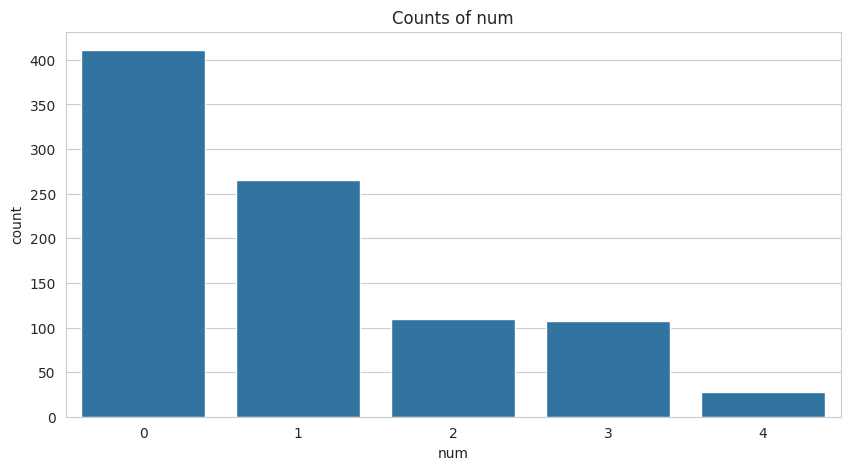

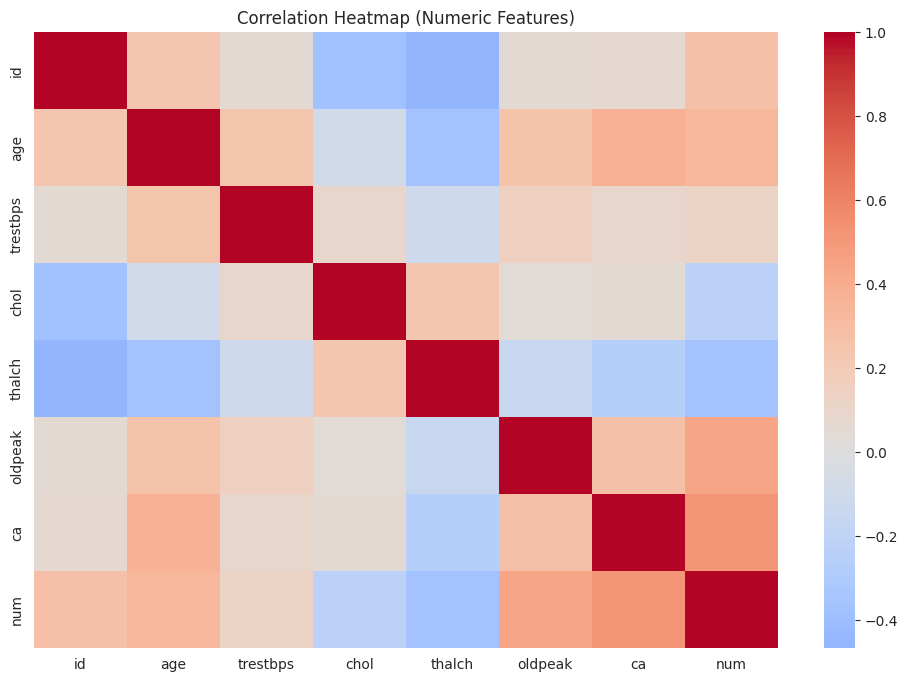


Outlier counts (IQR method):
           outlier_count
chol                183
trestbps             28
ca                   20
oldpeak              16
thalch                2
age                   0
id                    0


In [34]:
# ============================================================
# COMPLETE EDA BLOCK
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# 1) Basic structure + sanity checks
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nSample:\n", df.head(3))

# 2) Missing values / duplicates
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_table = pd.DataFrame({"missing_count": missing, "missing_%": missing_pct})
print("\nMissing values (count and %):\n", missing_table[missing_table["missing_count"] > 0])

dup_count = df.duplicated().sum()
print("\nDuplicate rows:", dup_count)

# Optional: drop duplicates if present (choose deliberately)
# df = df.drop_duplicates()

# 3) Summary statistics
print("\nNumeric summary:\n", df.describe().T)

# 4) Target distribution
if "target" in df.columns:
    print("\nTarget value counts:\n", df["target"].value_counts())
    print("\nTarget proportion:\n", df["target"].value_counts(normalize=True).round(3))

    plt.figure()
    sns.countplot(x="target", data=df)
    plt.title("Target Distribution (0 = No Disease, 1 = Disease)")
    plt.show()

# 5) Split columns into numeric vs categorical-ish
# (Many heart datasets use integers for categories, so we treat small-unique int cols as categorical)
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

def is_categorical_like(s, max_unique=10):
    return pd.api.types.is_integer_dtype(s) and s.nunique() <= max_unique

cat_cols = [c for c in numeric_cols if c != "target" and is_categorical_like(df[c])]
cont_cols = [c for c in numeric_cols if c not in cat_cols and c != "target"]

print("\nCategorical-like columns:", cat_cols)
print("Continuous columns:", cont_cols)

# 6) Univariate analysis: continuous distributions
for c in cont_cols:
    plt.figure()
    sns.histplot(df[c], kde=True, bins=30)
    plt.title(f"Distribution of {c}")
    plt.show()

# 7) Univariate analysis: categorical counts
for c in cat_cols:
    plt.figure()
    sns.countplot(x=c, data=df)
    plt.title(f"Counts of {c}")
    plt.show()

# 8) Bivariate vs target: continuous features
if "target" in df.columns:
    for c in cont_cols:
        plt.figure()
        sns.boxplot(x="target", y=c, data=df)
        plt.title(f"{c} vs Target (Boxplot)")
        plt.show()

        plt.figure()
        sns.kdeplot(data=df, x=c, hue="target", common_norm=False)
        plt.title(f"{c} vs Target (KDE)")
        plt.show()

# 9) Bivariate vs target: categorical features (stacked proportions)
if "target" in df.columns:
    for c in cat_cols:
        ct = pd.crosstab(df[c], df["target"], normalize="index")
        ct.plot(kind="bar", stacked=True)
        plt.title(f"Target Proportions by {c}")
        plt.xlabel(c)
        plt.ylabel("Proportion")
        plt.legend(title="target")
        plt.tight_layout()
        plt.show()

# 10) Correlation heatmap (numeric)
plt.figure(figsize=(12, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# 11) Feature-target correlation ranking (quick view)
if "target" in df.columns:
    target_corr = df[numeric_cols].corr()["target"].drop("target").sort_values(key=np.abs, ascending=False)
    print("\nCorrelation with target (sorted by absolute value):\n", target_corr)

# 12) Pairplot (can be heavy—use only top correlated features)
if "target" in df.columns:
    top_feats = target_corr.head(5).index.tolist() if "target_corr" in locals() else cont_cols[:5]
    cols_for_pair = top_feats + ["target"]
    sns.pairplot(df[cols_for_pair], hue="target", diag_kind="hist")
    plt.suptitle("Pairplot of Top Features vs Target", y=1.02)
    plt.show()

# 13) Outlier check using IQR (continuous only)
outlier_summary = {}
for c in cont_cols:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((df[c] < lower) | (df[c] > upper)).sum()
    outlier_summary[c] = outliers

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["outlier_count"]).sort_values("outlier_count", ascending=False)
print("\nOutlier counts (IQR method):\n", outlier_df)

# 14) Basic statistical association tests (optional but useful)
# - Chi-square for categorical-like vs target
# - Point-biserial correlation for continuous vs binary target
from scipy.stats import chi2_contingency, pointbiserialr

if "target" in df.columns:
    print("\nChi-square tests (categorical-like vs target):")
    for c in cat_cols:
        table = pd.crosstab(df[c], df["target"])
        if table.shape[0] > 1 and table.shape[1] > 1:
            chi2, p, dof, _ = chi2_contingency(table)
            print(f"{c:>10s}  p-value = {p:.4g}")

    print("\nPoint-biserial correlations (continuous vs target):")
    for c in cont_cols:
        r, p = pointbiserialr(df["target"], df[c])
        print(f"{c:>10s}  r = {r:+.3f}, p-value = {p:.4g}")


In [36]:
#Model Training without Pipelines: Train at least one classification model directly, without using the Scikit-Learn Pipeline object for preprocessing and model chaining. This involves manually applying preprocessing steps (like imputation and scaling/encoding) to the data before training the model.
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

# -----------------------------
# A) Pick the correct label column (robust)
# -----------------------------
candidate_labels = ["target", "output", "HeartDisease", "heart_disease", "num", "TenYearCHD", "label", "class"]

label_col = None
for c in candidate_labels:
    if c in df.columns:
        label_col = c
        break

if label_col is None:
    # Fallback: assume last column is the label (common in many CSVs)
    label_col = df.columns[-1]

print("✅ Using label column:", label_col)

# Split X/y
X = df.drop(columns=[label_col])
y = df[label_col]

# If y is not binary 0/1, try to make it binary safely
# (Some datasets use "num" with values 0..4, where >0 means disease)
if pd.api.types.is_numeric_dtype(y):
    unique_vals = sorted(pd.unique(y.dropna()))
    if len(unique_vals) > 2:
        y = (y > 0).astype(int)
else:
    # If y is strings like "Yes"/"No", map to 1/0 if possible
    y_str = y.astype(str).str.lower().str.strip()
    if set(y_str.unique()) <= {"yes", "no"}:
        y = y_str.map({"no": 0, "yes": 1}).astype(int)

print("✅ y class counts:\n", y.value_counts(dropna=False))

# -----------------------------
# B) Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# C) Decide numeric vs categorical columns
# -----------------------------
# Start with dtype-based detection
numeric_cols = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Many heart datasets store categorical features as integers.
# We'll treat these known heart-disease categorical columns as categorical IF they exist.
treat_as_categorical = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

for c in treat_as_categorical:
    if c in numeric_cols:
        numeric_cols.remove(c)
        categorical_cols.append(c)

# Remove duplicates (just in case)
categorical_cols = list(dict.fromkeys(categorical_cols))
numeric_cols = list(dict.fromkeys(numeric_cols))

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# -----------------------------
# D) Manual preprocessing (NO Pipeline)
# -----------------------------
# 1) Impute missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_num = None
X_test_num = None
if len(numeric_cols) > 0:
    X_train_num = num_imputer.fit_transform(X_train[numeric_cols])
    X_test_num = num_imputer.transform(X_test[numeric_cols])

X_train_cat = None
X_test_cat = None
if len(categorical_cols) > 0:
    # Convert to object to avoid OneHotEncoder issues with mixed numeric/cat types
    X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols].astype("object"))
    X_test_cat = cat_imputer.transform(X_test[categorical_cols].astype("object"))

# 2) Scale numeric features
scaler = StandardScaler()
if X_train_num is not None:
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

# 3) One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
if X_train_cat is not None:
    X_train_cat = encoder.fit_transform(X_train_cat)
    X_test_cat = encoder.transform(X_test_cat)

# 4) Combine final features
if X_train_num is not None and X_train_cat is not None:
    X_train_final = np.hstack([X_train_num, X_train_cat])
    X_test_final = np.hstack([X_test_num, X_test_cat])
elif X_train_num is not None:
    X_train_final = X_train_num
    X_test_final = X_test_num
elif X_train_cat is not None:
    X_train_final = X_train_cat
    X_test_final = X_test_cat
else:
    raise ValueError("No features available after preprocessing.")

print("✅ Final train shape:", X_train_final.shape)
print("✅ Final test shape:", X_test_final.shape)

# -----------------------------
# E) Train at least one classification model (NO Pipeline)
# -----------------------------
model = LogisticRegression(max_iter=3000)
model.fit(X_train_final, y_train)

# -----------------------------
# F) Evaluate
# -----------------------------
y_pred = model.predict(X_test_final)

# ROC-AUC needs probabilities; LogisticRegression supports predict_proba
y_prob = model.predict_proba(X_test_final)[:, 1]

print("\n=== Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Using label column: num
✅ y class counts:
 num
1    509
0    411
Name: count, dtype: int64
Numeric cols: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical cols: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']
✅ Final train shape: (736, 33)
✅ Final test shape: (184, 33)

=== Results ===
Accuracy: 0.8478260869565217
ROC-AUC: 0.9421329507412721

Confusion Matrix:
 [[65 17]
 [11 91]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82        82
           1       0.84      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184

